# Problem Statement
**beatit.ai** is one of the a music streaming startup in South Asia. 
They offer their services to millions of people, supported by advertising and paid subscriptions. It uses free or discounted trials to entice a customer who arrives on their platform. However, with the arrival of some new competitors the company’s churn rate is rising high. 

The task at hand is to predict the propensity of customer churn for the company. In the project, we would like to build a model which can predict in advance the customers who are at risk to cancel the beatit.ai music streaming service based on available data which is the user's past activity and interaction logs with the service. 

This will assist in identifying the probability of customer churn in the future so that preventive action can be taken proactively. 



# 1. Data Preparation
The first major task is to access and evaluate the data. The Data, to be used is coming from several sources and contains information about each user's subscription and streaming activities.

1.   User Profile data: **members.csv**. This data includes the user persona like user’s age, city and their registration time.
2.   User Logs data: **user_logs.csv**. This data consist of each user's listening behaviour in terms of their songs played in each day
3.   User Transaction data:  **transations.csv**. This data consist of details like payment method or whether the subscription was cancelled.
4.   Historical data: **train.csv** . This data consists of user IDs and whether these users have churned or not.


### 1.1 Importing packages

In [ ]:
!pip install "pydantic<2.0"


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#make sure your path is set to source folder
%cd /home

/home


In [3]:
!pwd

/home


In [4]:
!pip install --upgrade pandas


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
!pip install --upgrade dask


In [ ]:
!pip install scikit-optimize


In [ ]:
!pip install -U scikit-learn==1.2.2


In [ ]:
!pip install mlflow


In [ ]:
!pip uninstall -y pandas-profiling
!pip install ydata-profiling --upgrade


In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
#from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport
from ydata_profiling.config import Settings

In [6]:
# Setting up all directory


from scripts import utils

root_folder = "/home/"
data_directory = root_folder+"data/raw/"
data_profile_path = root_folder+"/data/profile_report/"
intermediate_data_path = root_folder+"data/interim/"
print("directory loaded")

directory loaded


In [7]:
print(data_directory)

/home/data/raw/


In [8]:
t = time.time()

 ### 1.2 Reading Data

In [ ]:
#this function is also available in utils.py

# def load_data(file_path_list):
#     data = []
#     for eachfile in file_path_list:
#         data.append(pd.read_csv(eachfile))
#     return data

In [9]:
%%time
members, user_logs, transactions, train  = utils.load_data( [
                                                            f"{data_directory}members_profile.csv",
                                                            f"{data_directory}userlogs.csv",
                                                            f"{data_directory}transactions_logs.csv",
                                                            f"{data_directory}churn_logs.csv"
                                                            ]
                                                          )

CPU times: user 12.2 s, sys: 1.85 s, total: 14 s
Wall time: 14 s


In [10]:
print(members.shape)
print(transactions.shape)
print(user_logs.shape)
print(train.shape)

(4348970, 6)
(4380726, 9)
(4828886, 9)
(385591, 2)


Since there are four data scources, it is important to understand the distribution of each data before joining them.

In [11]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,xYPYczYWex38H7EahgDJL/IzmJUGxLqibbtKaL2hGR8=,1,0,NaN,4,20161223
1,p80xUzvq8nBE/ExNjM9Q6/9TZ1meicF6cFZK0YBpgek=,1,0,NaN,4,20161223
2,qr8IVotaLLFgJ7b9bOAtSdFQq2BaefkkiZdUoggHoy8=,1,0,NaN,4,20161223
3,dKb/fL1RaKObYERPM1R2jO8Tjaj2076cWSTCoP5H3B4=,1,0,NaN,4,20161223
4,eOvxwd67VVh+j+0rnAwlh8+cVPwFzudbH03XHv9ZZAc=,1,0,NaN,4,20161223


The data is structured as:
* msno
* city
* bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d
* expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.

 Note that not every user in the dataset is available.

In [12]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20150930,20151108,0
1,o/7kLhrPCLGM9bhiD72KnzyESFAA8e0j0hQ5E0ZV6Uk=,23,0,0,149,1,20150930,20151031,0
2,fDxZokyT74FiBLf96N1JTmW0szBM+nHMFWsUaDQNFtw=,33,30,149,149,1,20151130,20160103,0
3,wWeIJemrBKSCN5eueejlHoZB3ns6RHD0itRv2SZOcEk=,41,30,99,99,1,20151130,20151231,0
4,Z23GxUZWHQpJOxwlGBSTHRf1KgRfb0/hTVgVWo4eDCc=,41,30,99,99,1,20151130,20151231,0


The data is structured as:
* msno: user id
* payment_method_id: payment method
* payment_plan_days: length of membership plan in days
* plan_list_price: in New Taiwan Dollar (NTD)
* actual_amount_paid: in New Taiwan Dollar (NTD)
* is_auto_renew
* transaction_date: format %Y%m%d
* membership_expire_date: format %Y%m%d
* is_cancel: whether or not the user canceled the membership in this transaction.

In [13]:
print('Total unique records: ',transactions.msno.nunique())

Total unique records:  385591


In [14]:
print(transactions.msno.nunique())
print(transactions.msno.value_counts())
print(transactions.msno.unique())
print(len(transactions.msno.unique()))

385591
msno
dnjJq1LhXBehL0VyhlHzYKKqVwMj7M9j7E7rRXY0HqE=    63
791c32ArWs05ZCpF+brfdTcgsMsOIKIxMCUe1Qh4OKE=    58
wZfaskjMFnyf/PFcQbe3dQORq1outZc0LTF1KDRpJfs=    53
Dsr+SqRiw0yQU60AqOqDdOwMjjPWw133GDrk7P3JzBw=    53
p/S2UK3sYOCW754a7ndGDujTIjg4bgGtHrKD2tXdTNw=    50
                                                ..
F0HlqpK/2PjUedeBD9AB1wviTT8xcEn3bMhryMqSm/M=     1
clxlxZ+Q7/R1CPM/4A/B+FAHAYUyLk02QZa8c+Z8r6k=     1
xOmlLFEduE8OY8OeL1VNVyINDbRiRfsBmfvxFyzc2Is=     1
t5CaXeEMJiOu9lilLxmcogHWHNibuHkHyEZrYW9OpkM=     1
lpI/SL3eCjJCnK99/QfmHL+5JgxF6PEID5OTV7bgwQY=     1
Name: count, Length: 385591, dtype: int64
['Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik='
 'o/7kLhrPCLGM9bhiD72KnzyESFAA8e0j0hQ5E0ZV6Uk='
 'fDxZokyT74FiBLf96N1JTmW0szBM+nHMFWsUaDQNFtw=' ...
 'IXp22siNgvhTmfGFdZDcupPTLuoPh86+fQ3NfSDGBnY='
 '66kirhXFwAiPeZkjvr8z5/ynFt5JqBg9u1FJAKi7r18='
 'lpI/SL3eCjJCnK99/QfmHL+5JgxF6PEID5OTV7bgwQY=']
385591


In [15]:
transactions[transactions['msno']=='Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=']

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20150930,20151108,0
472556,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20161031,20161208,0
915399,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20150731,20150908,0
1066031,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20151102,20151208,0
1694537,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20161130,20170108,0
1823958,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,31,149,149,1,20150408,20150508,0
2033069,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20151202,20160108,0
2260585,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20160731,20160908,0
2341720,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,0,0,149,1,20150430,20150608,0
2417838,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20160930,20161108,0


In [16]:
transactions[transactions['msno']=="Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik="]

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20150930,20151108,0
472556,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20161031,20161208,0
915399,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20150731,20150908,0
1066031,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20151102,20151208,0
1694537,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20161130,20170108,0
1823958,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,31,149,149,1,20150408,20150508,0
2033069,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20151202,20160108,0
2260585,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20160731,20160908,0
2341720,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,0,0,149,1,20150430,20150608,0
2417838,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,20160930,20161108,0


In [17]:
user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,kvn0x25i/D06AX1K3Sv9djeZA5oRsjPm8ysAl4rzBYs=,20151029,8,1,1,2,54,58,13573.105
1,kvn0x25i/D06AX1K3Sv9djeZA5oRsjPm8ysAl4rzBYs=,20160103,0,0,0,1,27,28,6233.864
2,kvn0x25i/D06AX1K3Sv9djeZA5oRsjPm8ysAl4rzBYs=,20160302,19,5,2,0,69,78,17517.728
3,kvn0x25i/D06AX1K3Sv9djeZA5oRsjPm8ysAl4rzBYs=,20160428,26,0,0,0,1,27,278.301
4,kvn0x25i/D06AX1K3Sv9djeZA5oRsjPm8ysAl4rzBYs=,20160628,2,0,0,0,0,2,11.345


The data is structured as:
* msno: user id
* date: format %Y%m%d
* num_25: # of songs played less than 25% of the song length
* num_50: # of songs played between 25% to 50% of the song length
* num_75: # of songs played between 50% to 75% of of the song length
* num_985: # of songs played between 75% to 98.5% of the song length
* num_100: # of songs played over 98.5% of the song length
* num_unq: # of unique songs played
* total_secs: total seconds played

In [18]:
print('Total unique records: ',user_logs.msno.nunique())

Total unique records:  324000


In [19]:
train.head()

,msno,is_churn
0,/7XuYVGXYHPggWsdtok0JEurQ10CtUO1Y8dDgy1/B0M=,0
1,gB3/kawEQSauWFArU9Z0kZo+ikw9GqJv0rXqNbpVnTY=,0
2,GovJmHUSsNem6DRayeG7VNFrhu4MVzX33wVY9g1UZAo=,0
3,2aFAPs3QmxD+bNcCe8beuWcI7SZHg1k+1irALOxiw3k=,0
4,FjEZAhwFky8sWoaNGTp+p/r3/hH30WxLr396iSho3gs=,0


Here, the column **msno** represents the unique identity of a service subscriber. 
The transaction data provides the information of each subscriber and their transactional details with respect to the service they have subscribed to. Similarly the data in the user logs table provides information about each user and their streaming behaviour on a daily level.

Here, the transaction and streaming logs are quite verbose with multiple records being recorded for a subscriber on a given date. On dates where there is no activity, no entries are found for a subscriber in these tables.

Additionaly, certain information in the above data have been masked for privacy concerns. 

> Definition of a **churned user**:
A subscriber is identified as a churned user if he/she fails to renew their subscription within 30 days after their current membership expires.
Upon inspecting the data, we can observe that a majority of beatit.ai's subscription length is 30 days, therefore it can be said that a lot of users re-subscribe every month.

 ### 1.2.1 Data conversion for memory reducton

In [ ]:
#this function is present in utils.py

# def compress_dataframes(list_of_dfs):
#     final_df = []
#     for eachdf in list_of_dfs:
#         original_size = (eachdf.memory_usage(index=True).sum())/ 1024**2
#         int_cols = list(eachdf.select_dtypes(include=['int']).columns)
#         float_cols = list(eachdf.select_dtypes(include=['float']).columns)
#         for col in int_cols:
#             if ((np.max(eachdf[col]) <= 127) and(np.min(eachdf[col] >= -128))):
#                 eachdf[col] = eachdf[col].astype(np.int8)
#             elif ((np.max(eachdf[col]) <= 32767) and(np.min(eachdf[col] >= -32768))):
#                 eachdf[col] = eachdf[col].astype(np.int16)
#             elif ((np.max(eachdf[col]) <= 2147483647) and(np.min(eachdf[col] >= -2147483648))):
#                 eachdf[col] = eachdf[col].astype(np.int32)
#             else:
#                 eachdf[col] = eachdf[col].astype(np.int64)
    
#         for col in float_cols:
#             eachdf[col] = eachdf[col].astype(np.float16)
#         compressed_size = (eachdf.memory_usage(index=True).sum())/ 1024**2
        
#         final_df.append((eachdf,original_size,compressed_size))
        
#     return final_df

In [20]:
%%time
members_c, transactions_c, user_logs_c = utils.compress_dataframes([members, transactions, user_logs])
members = members_c[0]
transactions = transactions_c[0]
user_logs = user_logs_c[0]

CPU times: user 439 ms, sys: 188 ms, total: 627 ms
Wall time: 625 ms


In [21]:
print("members DF before compress was in MB ,",members_c[1], "and after compress , ", members_c[2])
print("transactions DF before compress was in MB ,",transactions_c[1], "and after compress , ", transactions_c[2])
print("user_logs DF before compress was in MB ,",user_logs_c[1], "and after compress , ", user_logs_c[2])

members DF before compress was in MB , 199.08016967773438 and after compress ,  99.54014587402344
transactions DF before compress was in MB , 300.8007049560547 and after compress ,  104.44476890563965
user_logs DF before compress was in MB , 331.5734100341797 and after compress ,  119.73492050170898


 ### 1.3 EDA

In [ ]:
#function available in utils.py

# def count_plot(dataframe, list_of_columns):
#     final_plot = []
#     for eachcol in list_of_columns:
#         plt.figure(figsize=(15,5))
#         unique_features = dataframe[eachcol].unique()
#         if dataframe[eachcol].dtype =='int64':
#             unique_features=sorted(unique_features)
#         sns.countplot(x=eachcol, data=dataframe , order = unique_features)
#         plt.xlabel(eachcol)
#         plt.ylabel('Count')
#         plt.title("Frequency plot of {} Count".format(eachcol))
#         plt.show()

In [ ]:
# %matplotlib inline   
#if plots don't come, uncomment and run above cell one more time 

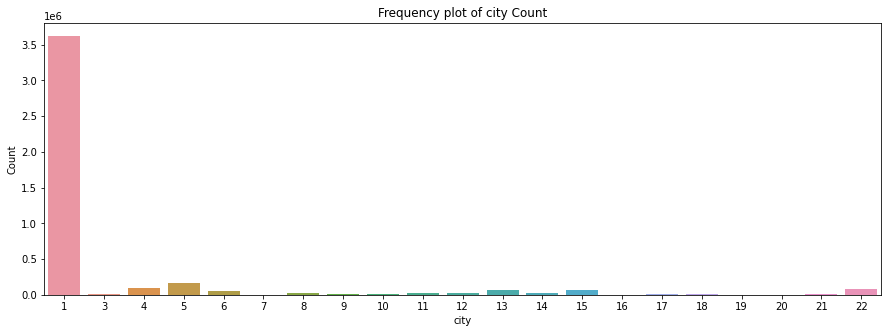

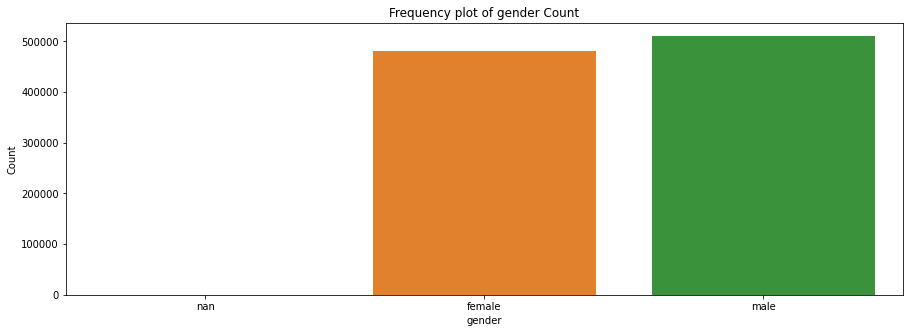

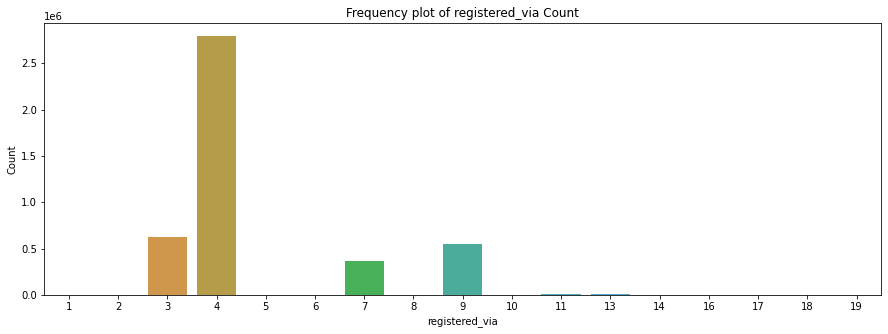

CPU times: user 2.37 s, sys: 1.24 s, total: 3.61 s
Wall time: 2.5 s


In [22]:
%%time
utils.count_plot(members, ['city','gender','registered_via'])

In [ ]:
filtered_members = utils.get_merge(members, train, on = 'msno') 

In [ ]:
churn_by_city = filtered_members.groupby('city')['is_churn'].mean().reset_index()
churn_by_city.rename(columns={'is_churn': 'churn_rate'}, inplace=True)

In [ ]:
# in the above city, do bivariate analysis and see how the churn rate in for cities other than 1

plt.figure(figsize=(8, 5))
sns.barplot(data=churn_by_city, x='city', y='churn_rate', palette='coolwarm')
plt.title('Churn Rate per City')
plt.xlabel('City')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)  # Since churn is a rate between 0 and 1
plt.tight_layout()
plt.show()


**Observation:**

* There are total of 21 Cities Encoded ( there is no City "2" in the data set). 
* There are Class of "3", "4", "7", "9", "11","13" listed as registration method.  

Kindly note that there is additional "10", and "16" class of cities listed in Member Data set but there are missing when we merged the data set ( see below). 
*  There are almost equal percentage of Male and Female, but more than half of the data is missing in gender field. We have see how to fill the missing entries or label them as third category. 

> Details of Registration init time can't be explored without converting the column to datatime.

In [ ]:
#this function is also available in utils.py

# def fix_time_in_df(dataframe, column_name, expand=False):
#     if not expand:
#         dataframe[column_name] = dataframe[column_name].astype('str')
#         return pd.to_datetime(dataframe[column_name])
#     else:
#         dataframe_new = dataframe.copy()
#         dataframe_new[column_name] = dataframe_new[column_name].astype('str')
#         dataframe_new[column_name] = pd.to_datetime(dataframe_new[column_name])
#         #Extracting the date time year component
#         dataframe_new[f"{column_name}_year"] = pd.DatetimeIndex(dataframe_new[column_name]).year
#         #Extracting the date time year component
#         dataframe_new[f"{column_name}_month"] = pd.DatetimeIndex(dataframe_new[column_name]).month
#         #Extracting the date time year component
#         dataframe_new[f"{column_name}_day"] = pd.DatetimeIndex(dataframe_new[column_name]).day_name()
      
#         return dataframe_new
    

In [ ]:
print(pd.to_datetime(members['registration_init_time']).head())
pd.DatetimeIndex(members['registration_init_time']).year

In [ ]:
%%time
members_new = utils.fix_time_in_df(members, 'registration_init_time', expand=True)

In [ ]:
members_new.head()

In [ ]:
# Check the max and min dates of the date

print("The last recorded date time for registration is: ", members_new.registration_init_time.max())
print("The first recorded date time for registration is: ",members_new.registration_init_time.min())

In [ ]:
def count_plot(dataframe, list_of_columns):
    for eachcol in list_of_columns:
        plt.figure(figsize=(15,5))
        unique_features = dataframe[eachcol].unique()
        if np.issubdtype(dataframe[eachcol].dtype, np.integer):
            unique_features=sorted(unique_features)
        sns.countplot(x=eachcol, data=dataframe , order = unique_features)
        plt.xlabel(eachcol)
        plt.ylabel('Count')
        plt.title("Frequency plot of {} Count".format(eachcol))
        plt.show()
        
count_plot(members_new,['registration_init_time_year','registration_init_time_month','registration_init_time_day'])        

In [ ]:
utils.count_plot(members_new,['registration_init_time_year','registration_init_time_month','registration_init_time_day'])

**Observations:**

* Registration trend has increased yearly, though there was a dip in 2017. Due to data upto few months in 2017, there is a dip.
* Registration monthly trends are high in year end and year starting months. In between there is a smooth valley formation.
* Registration daily trends are high on weekends.

In [ ]:
%%time
members['registration_init_time'] = utils.fix_time_in_df(members, 'registration_init_time', expand=False)

In [ ]:
members.head()

### 1.3.1 EDA using Pandas Profiling

In [ ]:
#this function is also available in utils.py
# import time

# def get_data_profile(dataframe,html_save_path, 
#                      embed_in_cell=True,take_sample=False, sample_frac=0.5, dataframe_name="data"):
#     if take_sample:
#         dataframe = dataframe.sample(frac=sample_frac)
#     if embed_in_cell:
#         profile = ProfileReport(dataframe, title=f"{dataframe_name} Data Summary Report")
#         return profile.to_notebook_iframe()
#     else:
#         profile = ProfileReport(dataframe, title=f"{dataframe_name} Data Summary Report")
#         timestamp = str(int(time.time()))
#         filename = f"{dataframe_name}_data_profile_{timestamp}"
#         profile.to_file(html_save_path+filename+".html")
#         return "Your Data Profile has been saved at .. ",html_save_path+filename+".html"

In [23]:
def get_data_profile(dataframe, html_save_path, 
                     embed_in_cell=True, take_sample=False, sample_frac=0.5, dataframe_name="data"):
    
    if take_sample:
        dataframe = dataframe.sample(frac=sample_frac)
    
    # Set config with known font
    config = Settings()
    config.plot.font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
    
    if embed_in_cell:
        profile = ProfileReport(dataframe, title=f"{dataframe_name} Data Summary Report", config=config)
        return profile.to_notebook_iframe()
    else:
        profile = ProfileReport(dataframe, title=f"{dataframe_name} Data Summary Report", config=config)
        timestamp = str(int(time.time()))
        filename = f"{dataframe_name}_data_profile_{timestamp}"
        profile.to_file(html_save_path + filename + ".html")
        return "Your Data Profile has been saved at .. ", html_save_path + filename + ".html"


In [24]:
from ydata_profiling import ProfileReport
from ydata_profiling.config import Settings
import time

def get_data_profile(dataframe, html_save_path,
                     embed_in_cell=True, take_sample=False, sample_frac=0.5, dataframe_name="data"):

    if take_sample:
        dataframe = dataframe.sample(frac=sample_frac)

    # Set a valid TTF font path explicitly as a string (especially needed on Windows)
    font_path = r"C:\Windows\Fonts\arial.ttf"  # Or another .ttf font file you have
    config = Settings()
    config.plot.font_path = font_path  # explicitly set as string

    if embed_in_cell:
        profile = ProfileReport(dataframe, title=f"{dataframe_name} Data Summary Report", config=config)
        return profile.to_notebook_iframe()
    else:
        profile = ProfileReport(dataframe, title=f"{dataframe_name} Data Summary Report", config=config)
        timestamp = str(int(time.time()))
        filename = f"{dataframe_name}_data_profile_{timestamp}"
        profile.to_file(html_save_path + filename + ".html")
        return "Your Data Profile has been saved at .. ", html_save_path + filename + ".html"


In [25]:
!pip install matplotlib wordcloud


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [26]:
%%time
#taking sample
get_data_profile(members,html_save_path='', 
                     embed_in_cell=True,take_sample=True, sample_frac=0.01, 
                dataframe_name='members')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

TypeError: argument 1 must be str, bytes or bytearray, not PosixPath

<Figure size 432x288 with 0 Axes>

**Observations**:


#Write your observations from the profile report created above



In [27]:
%%time
utils.get_data_profile(train,html_save_path=None, 
                     embed_in_cell=True,take_sample=False, sample_frac=0.01, 
                dataframe_name='Train')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Only supported for TrueType fonts

<Figure size 432x288 with 0 Axes>

In [ ]:
# assignment is to try it out without sampling in the above cell

In [ ]:
%%time
utils.get_data_profile(user_logs,html_save_path=data_profile_path, 
                     embed_in_cell=False,take_sample=True, sample_frac=0.001, 
                dataframe_name='user_logs')

In [ ]:
# If the columns / features are higly correlated, its a indcation that all these varaiables have similar effect on the target variable
# We can take only one feature of all these columns. 

**Observations:**


#Write your observations from the profile report created above


### 1.5 Feature Engineering

#### Registration Features

In [ ]:
#these functions are available in utils.py

# def get_data_describe(dataframe,round_num=2):
#     return round(dataframe.describe(),round_num)

# def get_data_na_values(dataframe, round_num=2):
#     return pd.DataFrame({'%missing_values':round(dataframe.isna().sum()/dataframe.shape[0],round_num)})

# def get_fill_na_dataframe(dataframe, column_name, value='mean'):
#     if value != 'mean' and value !='mode':
#         return dataframe[column_name].fillna(value)
#     elif value == 'mean':
#         value = dataframe[column_name].mean()
#         return dataframe[column_name].fillna(value)
#     elif value == 'mode':
#         value = dataframe[column_name].mode()
#         return dataframe[column_name].fillna(value)

# def get_convert_column_dtype(dataframe, column_name, data_type='str'):
#     if data_type == 'str':
#         return dataframe[column_name].astype('str')
#     elif data_type == 'int':
#         return dataframe[column_name].astype('int')
#     elif data_type == 'float':
#         return dataframe[column_name].astype('float')

In [28]:
utils.get_data_describe(members)

,city,bd,registered_via,registration_init_time
count,4348970.00,4348970.0,4348970.00,4348970.00
mean,2.58,6.3,4.77,20158028.88
std,4.34,15.2,1.93,6291.16
min,1.00,-6998.0,1.00,20150101.00
25%,1.00,0.0,4.00,20151024.00
50%,1.00,0.0,4.00,20160315.00
75%,1.00,0.0,4.00,20160914.00
max,22.00,2016.0,19.00,20170429.00


In [29]:
members.describe()

,city,bd,registered_via,registration_init_time
count,4.348970e+06,4.348970e+06,4.348970e+06,4.348970e+06
mean,2.582389e+00,6.297052e+00,4.765943e+00,2.015803e+07
std,4.340165e+00,1.519892e+01,1.933186e+00,6.291162e+03
min,1.000000e+00,-6.998000e+03,1.000000e+00,2.015010e+07
25%,1.000000e+00,0.000000e+00,4.000000e+00,2.015102e+07
50%,1.000000e+00,0.000000e+00,4.000000e+00,2.016032e+07
75%,1.000000e+00,0.000000e+00,4.000000e+00,2.016091e+07
max,2.200000e+01,2.016000e+03,1.900000e+01,2.017043e+07


In [30]:
utils.get_data_na_values(members)

,%missing_values
msno,0.00
city,0.00
bd,0.00
gender,0.77
registered_via,0.00
registration_init_time,0.00


In [31]:
#Replacing missing values in gender
members['gender'] = utils.get_fill_na_dataframe(members, 'gender', value="others")

In [32]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4348970 entries, 0 to 4348969
Data columns (total 6 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   msno                    object
 1   city                    int8  
 2   bd                      int16 
 3   gender                  object
 4   registered_via          int8  
 5   registration_init_time  int32 
dtypes: int16(1), int32(1), int8(2), object(2)
memory usage: 99.5+ MB


In [33]:
members['registered_via'] = utils.get_convert_column_dtype(members, 'registered_via', data_type='str')
members['city'] = utils.get_convert_column_dtype(members, 'city', data_type='str')

In [34]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4348970 entries, 0 to 4348969
Data columns (total 6 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   msno                    object
 1   city                    object
 2   bd                      int16 
 3   gender                  object
 4   registered_via          object
 5   registration_init_time  int32 
dtypes: int16(1), int32(1), object(4)
memory usage: 157.6+ MB


In [35]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,xYPYczYWex38H7EahgDJL/IzmJUGxLqibbtKaL2hGR8=,1,0,others,4,20161223
1,p80xUzvq8nBE/ExNjM9Q6/9TZ1meicF6cFZK0YBpgek=,1,0,others,4,20161223
2,qr8IVotaLLFgJ7b9bOAtSdFQq2BaefkkiZdUoggHoy8=,1,0,others,4,20161223
3,dKb/fL1RaKObYERPM1R2jO8Tjaj2076cWSTCoP5H3B4=,1,0,others,4,20161223
4,eOvxwd67VVh+j+0rnAwlh8+cVPwFzudbH03XHv9ZZAc=,1,0,others,4,20161223


#### Transactional features

The data here is present in one-many format, as one user can have multiple transaction samples. Therefore while joining the entire data, we need to convert the transactions data in one-one format.
But before that let's format the data and process it

In [36]:
utils.get_data_describe(transactions)

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
count,4380726.00,4380726.00,4380726.00,4380726.00,4380726.00,4380726.00,4380726.00,4380726.00
mean,39.87,30.56,122.55,122.13,0.89,20160886.85,20161992.17,0.01
std,2.79,13.35,63.40,64.03,0.31,5375.31,6017.86,0.11
min,2.00,0.00,0.00,0.00,0.00,20150101.00,19700101.00,0.00
25%,40.00,30.00,99.00,99.00,1.00,20160318.00,20160419.00,0.00
50%,41.00,30.00,99.00,99.00,1.00,20160813.00,20160914.00,0.00
75%,41.00,30.00,149.00,149.00,1.00,20161130.00,20161231.00,0.00
max,41.00,450.00,2000.00,2000.00,1.00,20170228.00,20170331.00,1.00


In [37]:
#Missing Values
utils.get_data_na_values(transactions)

,%missing_values
msno,0.0
payment_method_id,0.0
payment_plan_days,0.0
plan_list_price,0.0
actual_amount_paid,0.0
is_auto_renew,0.0
transaction_date,0.0
membership_expire_date,0.0
is_cancel,0.0


In [38]:
%%time
transactions['transaction_date'] = utils.fix_time_in_df(transactions, 'transaction_date', expand=False)
transactions['membership_expire_date'] = utils.fix_time_in_df(transactions, 'membership_expire_date', expand=False)

CPU times: user 4.22 s, sys: 496 ms, total: 4.72 s
Wall time: 4.67 s


In [39]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=,39,30,149,149,1,2015-09-30,2015-11-08,0
1,o/7kLhrPCLGM9bhiD72KnzyESFAA8e0j0hQ5E0ZV6Uk=,23,0,0,149,1,2015-09-30,2015-10-31,0
2,fDxZokyT74FiBLf96N1JTmW0szBM+nHMFWsUaDQNFtw=,33,30,149,149,1,2015-11-30,2016-01-03,0
3,wWeIJemrBKSCN5eueejlHoZB3ns6RHD0itRv2SZOcEk=,41,30,99,99,1,2015-11-30,2015-12-31,0
4,Z23GxUZWHQpJOxwlGBSTHRf1KgRfb0/hTVgVWo4eDCc=,41,30,99,99,1,2015-11-30,2015-12-31,0


In [42]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380726 entries, 0 to 4380725
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   msno                    object        
 1   payment_method_id       int8          
 2   payment_plan_days       int16         
 3   plan_list_price         int16         
 4   actual_amount_paid      int16         
 5   is_auto_renew           int8          
 6   transaction_date        datetime64[ns]
 7   membership_expire_date  datetime64[ns]
 8   is_cancel               int8          
dtypes: datetime64[ns](2), int16(3), int8(3), object(1)
memory usage: 137.9+ MB


In [ ]:
#these functions are also available in utils.py

# def get_groupby(dataframe, by_column, agg_dict=None, agg_func = 'mean', simple_agg_flag=True, reset_index=True):
#     if reset_index:
#         if simple_agg_flag:
#             return dataframe.groupby(by_column).agg(agg_func).reset_index()
#         else:
#             return dataframe.groupby(by_column).agg(agg_dict).reset_index()
#     else:
#         if simple_agg_flag:
#             return dataframe.groupby(by_column).agg(agg_func)
#         else:
#             return dataframe.groupby(by_column).agg(agg_dict)
        
# def get_merge(dataframe1, dataframe2, on, axis=1, how='inner'):
#     return dataframe1.merge(dataframe2, on=on,how=how)

In [40]:
transaction_base = utils.get_groupby(transactions,'msno', agg_dict=None, agg_func = 'mean', simple_agg_flag=True, reset_index=True)
transaction_base.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,41.0000,30.0000,149.0000,149.0000,1.0,2016-08-30 08:00:00,2016-09-29 18:00:00,0.0
1,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,41.0000,30.0000,149.0000,149.0000,1.0,2016-09-04 08:00:00,2016-10-04 18:00:00,0.0
2,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,37.8125,34.1875,160.1875,160.1875,0.0,2016-04-16 00:00:00,2016-05-22 06:00:00,0.0
3,++1G0wVY14Lp0VXak1ymLhPUdXPSFJVBnjWwzGxBKJs=,41.0000,30.0000,99.0000,99.0000,1.0,2016-05-24 22:40:00,2016-06-24 08:00:00,0.0
4,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,41.0000,30.0000,99.0000,99.0000,1.0,2016-10-19 15:00:00,2016-11-18 21:00:00,0.0


In [41]:
transaction_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385591 entries, 0 to 385590
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   msno                    385591 non-null  object        
 1   payment_method_id       385591 non-null  float64       
 2   payment_plan_days       385591 non-null  float64       
 3   plan_list_price         385591 non-null  float64       
 4   actual_amount_paid      385591 non-null  float64       
 5   is_auto_renew           385591 non-null  float64       
 6   transaction_date        385591 non-null  datetime64[ns]
 7   membership_expire_date  385591 non-null  datetime64[ns]
 8   is_cancel               385591 non-null  float64       
dtypes: datetime64[ns](2), float64(6), object(1)
memory usage: 26.5+ MB


In [43]:
agg_dict = { 'transaction_date':'max', 'membership_expire_date':'max' }
transaction_date = utils.get_groupby(transactions,'msno', agg_dict=agg_dict, agg_func = 'mean', simple_agg_flag=False, reset_index=True)
transaction_date.head()

,msno,transaction_date,membership_expire_date
0,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,2017-02-15,2017-03-15
1,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,2017-02-20,2017-03-20
2,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,2017-02-24,2017-03-26
3,++1G0wVY14Lp0VXak1ymLhPUdXPSFJVBnjWwzGxBKJs=,2017-02-09,2017-03-09
4,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,2017-02-04,2017-03-04


In [44]:
transaction_final = utils.get_merge(transaction_base, transaction_date, on = 'msno') 
transaction_final.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date_x,membership_expire_date_x,is_cancel,transaction_date_y,membership_expire_date_y
0,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,41.0000,30.0000,149.0000,149.0000,1.0,2016-08-30 08:00:00,2016-09-29 18:00:00,0.0,2017-02-15,2017-03-15
1,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,41.0000,30.0000,149.0000,149.0000,1.0,2016-09-04 08:00:00,2016-10-04 18:00:00,0.0,2017-02-20,2017-03-20
2,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,37.8125,34.1875,160.1875,160.1875,0.0,2016-04-16 00:00:00,2016-05-22 06:00:00,0.0,2017-02-24,2017-03-26
3,++1G0wVY14Lp0VXak1ymLhPUdXPSFJVBnjWwzGxBKJs=,41.0000,30.0000,99.0000,99.0000,1.0,2016-05-24 22:40:00,2016-06-24 08:00:00,0.0,2017-02-09,2017-03-09
4,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,41.0000,30.0000,99.0000,99.0000,1.0,2016-10-19 15:00:00,2016-11-18 21:00:00,0.0,2017-02-04,2017-03-04


In [45]:
utils.get_data_describe(transaction_final)

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date_x,membership_expire_date_x,is_cancel,transaction_date_y,membership_expire_date_y
count,385591.00,385591.00,385591.00,385591.00,385591.00,385591,385591,385591.00,385591,385591
mean,39.40,33.03,133.92,133.17,0.85,2016-08-27 11:13:39.208593920,2016-09-28 22:11:33.873018112,0.01,2017-02-08 17:16:57.518562816,2017-03-12 20:45:31.694463488
min,3.00,1.00,0.00,0.00,0.00,2015-01-02 00:00:00,1993-07-18 00:00:00,0.00,2015-01-02 00:00:00,2017-02-01 00:00:00
25%,38.81,30.00,99.00,99.00,1.00,2016-06-17 04:14:07.058823424,2016-07-19 14:07:03.529411840,0.00,2017-02-05 00:00:00,2017-03-05 00:00:00
50%,41.00,30.00,99.00,99.00,1.00,2016-08-24 03:41:32.307692288,2016-09-25 19:12:00,0.00,2017-02-14 00:00:00,2017-03-14 00:00:00
75%,41.00,30.00,149.00,149.00,1.00,2016-11-14 17:08:34.285714176,2016-12-15 12:00:00,0.00,2017-02-22 00:00:00,2017-03-22 00:00:00
max,41.00,450.00,2000.00,2000.00,1.00,2017-02-28 00:00:00,2017-03-18 08:00:00,1.00,2017-02-28 00:00:00,2017-03-31 00:00:00
std,3.27,25.08,110.10,110.40,0.34,NaN,NaN,0.04,NaN,NaN


In [46]:
%%time
utils.get_data_profile(transaction_final,html_save_path=None, 
                     embed_in_cell=True,take_sample=False, sample_frac=0.01, 
                dataframe_name='Transaction_Final')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:08<00:00,  1.37it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Only supported for TrueType fonts

<Figure size 432x288 with 0 Axes>

**Observations**:


#Write your observations from the profile report created above


#### User Behavioural Features

Like the transactions data, the data here is also present in one-many format.  Therefore this data also has to converted in one-one format.

In [47]:
utils.get_data_describe(user_logs)

,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,4828886.00,4828886.00,4828886.00,4828886.00,4828886.00,4828886.00,4828886.00,4828886.0
mean,20160860.03,6.93,1.69,1.04,1.11,28.28,28.77,NaN
std,5344.84,14.63,4.38,2.15,2.48,37.40,31.84,NaN
min,20150101.00,0.00,0.00,0.00,0.00,0.00,1.00,-inf
25%,20160323.00,1.00,0.00,0.00,0.00,6.00,8.00,1843.0
50%,20160812.00,2.00,1.00,0.00,0.00,16.00,18.00,4396.0
75%,20161129.00,7.00,2.00,1.00,1.00,35.00,38.00,9528.0
max,20170228.00,2574.00,846.00,327.00,784.00,8396.00,2020.00,inf


In [48]:
#Missing Values
utils.get_data_na_values(user_logs)

,%missing_values
msno,0.0
date,0.0
num_25,0.0
num_50,0.0
num_75,0.0
num_985,0.0
num_100,0.0
num_unq,0.0
total_secs,0.0


In [ ]:
#this function is also available in utils.py 

# def get_fix_skew_with_log(dataframe, columns, replace_inf = True, replace_inf_with = 0):
#     if replace_inf:
#         dataframe_log = np.log(dataframe[columns]).replace([np.inf, -np.inf], replace_inf_with)
#         return pd.concat([dataframe_log, dataframe.drop(columns,axis=1)], axis=1)
#     else:
#         dataframe_log = np.log(dataframe[columns])
#         return pd.concat([dataframe_log, dataframe.drop(columns,axis=1)], axis=1)
        

In [49]:
user_logs_transformed = utils.get_fix_skew_with_log(user_logs, ['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs'], 
                                              replace_inf = True, replace_inf_with = 0)
user_logs_transformed.head()

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,msno,date
0,2.079442,0.000000,0.000000,0.693147,3.988984,4.060443,9.515625,kvn0x25i/D06AX1K3Sv9djeZA5oRsjPm8ysAl4rzBYs=,20151029
1,0.000000,0.000000,0.000000,0.000000,3.295837,3.332205,8.734375,kvn0x25i/D06AX1K3Sv9djeZA5oRsjPm8ysAl4rzBYs=,20160103
2,2.944439,1.609438,0.693147,0.000000,4.234107,4.356709,9.773438,kvn0x25i/D06AX1K3Sv9djeZA5oRsjPm8ysAl4rzBYs=,20160302
3,3.258096,0.000000,0.000000,0.000000,0.000000,3.295837,5.628906,kvn0x25i/D06AX1K3Sv9djeZA5oRsjPm8ysAl4rzBYs=,20160428
4,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,2.427734,kvn0x25i/D06AX1K3Sv9djeZA5oRsjPm8ysAl4rzBYs=,20160628


In [50]:
utils.get_data_describe(user_logs_transformed)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,date
count,4828886.00,4828886.00,4828886.00,4828886.00,4828886.00,4828886.00,4828648.00,4828886.00
mean,1.14,0.38,0.25,0.26,2.62,2.78,NaN,20160860.03
std,1.19,0.69,0.52,0.54,1.31,1.18,0.00,5344.84
min,0.00,0.00,0.00,0.00,0.00,0.00,-6.91,20150101.00
25%,0.00,0.00,0.00,0.00,1.79,2.08,7.51,20160323.00
50%,0.69,0.00,0.00,0.00,2.77,2.89,8.38,20160812.00
75%,1.95,0.69,0.00,0.00,3.56,3.64,9.16,20161129.00
max,7.85,6.74,5.79,6.66,9.04,7.61,11.09,20170228.00


In [51]:
user_logs_transformed.drop('date', axis=1, inplace= True)

In [52]:
user_logs_transformed_final = utils.get_groupby(user_logs_transformed,'msno', agg_dict=None, agg_func = 'mean', simple_agg_flag=True, reset_index=True)
user_logs_transformed_final.head()

,msno,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,1.212655,0.426138,0.471913,0.584749,2.389540,2.062883,8.075358
1,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,1.174083,0.585266,0.310613,0.425150,1.780883,2.394411,7.569336
2,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0.276101,0.268682,0.061034,0.176559,2.661876,2.832618,8.239800
3,++1G0wVY14Lp0VXak1ymLhPUdXPSFJVBnjWwzGxBKJs=,0.658754,0.155307,0.198628,0.180648,2.417614,2.583583,7.972412
4,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,0.346574,0.173287,0.000000,0.000000,3.005417,2.812240,8.566406


In [ ]:
%%time
utils.get_data_profile(user_logs_transformed_final,html_save_path=None, 
                     embed_in_cell=True,take_sample=False, sample_frac=0.01, 
                dataframe_name='user_logs_transformed_final')

**Observations**:


#Write your observations from the profile report created above


### 1.6 Joining the dataset

In [53]:
print(members.shape)
print(train.shape)
print(transaction_final.shape)
print(user_logs_transformed_final.shape)

(4348970, 6)
(385591, 2)
(385591, 11)
(324000, 8)


In [54]:
%%time
train_df_v01 = utils.get_merge(members, train, on='msno', axis=1, how='inner')
train_df_v02 = utils.get_merge(train_df_v01, transaction_final, on='msno', axis=1, how='inner')
train_df_final = utils.get_merge(train_df_v02, user_logs_transformed_final, on='msno', axis=1, how='inner')
train_df_final.head()

CPU times: user 4.61 s, sys: 1.05 s, total: 5.66 s
Wall time: 5.58 s


,msno,city,bd,gender,registered_via,registration_init_time,is_churn,payment_method_id,payment_plan_days,plan_list_price,...,is_cancel,transaction_date_y,membership_expire_date_y,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,/7XuYVGXYHPggWsdtok0JEurQ10CtUO1Y8dDgy1/B0M=,1,0,others,7,20161223,0,41.0,30.0,149.0,...,0.0,2017-02-22,2017-03-22,0.000000,0.000000,0.0,0.000000,2.289867,2.289867,7.808594
1,gB3/kawEQSauWFArU9Z0kZo+ikw9GqJv0rXqNbpVnTY=,1,0,others,7,20161223,0,41.0,30.0,99.0,...,0.0,2017-02-23,2017-03-23,0.274653,0.000000,0.0,0.000000,2.845647,2.281930,8.363281
2,2aFAPs3QmxD+bNcCe8beuWcI7SZHg1k+1irALOxiw3k=,15,23,female,4,20161224,0,40.0,30.0,149.0,...,0.0,2017-02-27,2017-03-26,0.000000,0.000000,0.0,0.000000,4.708342,4.683700,10.236328
3,FjEZAhwFky8sWoaNGTp+p/r3/hH30WxLr396iSho3gs=,1,0,others,7,20161225,0,41.0,30.0,99.0,...,0.0,2017-02-24,2017-03-24,0.621227,0.173287,0.0,0.346574,3.070758,2.640511,8.630859
4,C5PNTuQxUQmHOXPptQnokhqH1XQoAHHL8pMWIX0nAh0=,1,0,others,7,20161225,0,41.0,30.0,99.0,...,0.0,2017-02-24,2017-03-24,0.000000,0.000000,0.0,0.000000,1.595831,1.499937,7.083333


In [55]:
train_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324000 entries, 0 to 323999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   msno                      324000 non-null  object        
 1   city                      324000 non-null  object        
 2   bd                        324000 non-null  int16         
 3   gender                    324000 non-null  object        
 4   registered_via            324000 non-null  object        
 5   registration_init_time    324000 non-null  int32         
 6   is_churn                  324000 non-null  int64         
 7   payment_method_id         324000 non-null  float64       
 8   payment_plan_days         324000 non-null  float64       
 9   plan_list_price           324000 non-null  float64       
 10  actual_amount_paid        324000 non-null  float64       
 11  is_auto_renew             324000 non-null  float64       
 12  tr

In [ ]:
%%time
utils.get_data_profile(train_df_final,html_save_path=None, 
                     embed_in_cell=True,take_sample=False, sample_frac=0.01, 
                dataframe_name='train_df_final')

**Observations**:

#Write your observations from the profile report created above


In [ ]:
#members_v01_sample_joinfinal.drop(['registration_init_time','date','transaction_date','membership_expire_date'],axis=1,inplace=True)

### 1.6.1 Saving the dataset

In [ ]:
#this function is also available in utils.py
# import time
# def get_save_intermediate_data(dataframe, path, filename="data_interim"):
#     filename = filename+"_"+str(int(time.time()))+".csv"
#     dataframe.to_csv(path+filename)
#     return "Data Saved Here :",path+filename

In [57]:
print(intermediate_data_path)

/home/data/interim/


In [59]:
from pathlib import Path

path = '/home/data/interim/'
print(Path(path).exists())
print(Path(path).is_dir())


True
True


In [60]:
%%time
utils.get_save_intermediate_data(train_df_final, path=intermediate_data_path, filename="final_train_data_interim")

CPU times: user 6.01 s, sys: 210 ms, total: 6.22 s
Wall time: 6.22 s


('Data Saved Here :',
 '/home/data/interim/final_train_data_interim_1748666766.csv')